In [2]:
import math
import numpy as np
import time
import matplotlib.pyplot as plt
import sympy as sp
import C_GMRES_sympy as C
# sympy関数のnumpyへの変換
def numpyfy(arg,f):
    return sp.lambdify(arg, f, "numpy")


# 変数とそのベクトル化

In [3]:
#モデル変数
x, y,z= sp.symbols('x y z')
xt,yt,zt=sp.symbols('xt yt zt')
ux, uy= sp.symbols('ux uy')
lmx,lmy,lmz=sp.symbols('lmx lmy lmz')
x_ob,y_ob,z_ob=sp.symbols('x_ob,y_ob,z_ob')

#vector化
u=sp.Matrix([ux,uy])
xs=sp.Matrix([x,y,z])
obs=sp.Matrix([x_ob,y_ob,z_ob])
xbar=sp.Matrix([x-x_ob,y-y_ob,z-z_ob])
t=sp.Matrix([xt,yt,zt])
lm=sp.Matrix([lmx,lmy,lmz])

In [18]:
#定数
barcoef=0.15 

umax=sp.Matrix([0.5,0.5])

# モデル式

 「非線形最適制御入門」の例

In [23]:
f=sp.Matrix([y,(1-x*x-y*y)*y-x+ux,0])
f

Matrix([
[                            y],
[ux - x + y*(-x**2 - y**2 + 1)],
[                            0]])

In [34]:
class Model:
    def __init__(self):
        _func=numpyfy((xs,u),f)
        self.func=lambda u,xs:_func(xs,u).flatten()    


# 評価関数 (Hamiltonian)

In [46]:
t.T*t

Matrix([[xt**2 + yt**2 + zt**2]])

In [50]:
#J=(t.T*t +u.T*u+ xbar.T*xbar)/2
A=sp.Matrix([[1,0],[0,0]])
J=(t.T*t +u.T*A*u+xbar.T*xbar)/2 -0.01*sp.Matrix([uy])

barrier=u.T*u-umax.T*umax #障壁関数
H= J + f.T*lm  +barcoef*barrier
H

Matrix([[lmx*y + lmy*(ux - x + y*(-x**2 - y**2 + 1)) + 0.65*ux**2 + 0.15*uy**2 - 0.01*uy + xt**2/2 + yt**2/2 + zt**2/2 + (x - x_ob)**2/2 + (y - y_ob)**2/2 + (z - z_ob)**2/2 - 0.075]])

In [26]:
Hu=sp.Matrix([H.diff(ux),H.diff(uy)])
Hx=sp.Matrix([H.diff(x),H.diff(y),H.diff(z)])
Ht=sp.Matrix([H.diff(xt),H.diff(yt),H.diff(zt)])

In [27]:
Hu

Matrix([
[lmy + 1.3*ux],
[      1.3*uy]])

In [28]:
Hx

Matrix([
[              lmy*(-2*x*y - 1) + x - x_ob],
[lmx + lmy*(-x**2 - 3*y**2 + 1) + y - y_ob],
[                                 z - z_ob]])

In [39]:
Ht

Matrix([
[xt],
[yt],
[zt]])

# Test

In [51]:
def test(maxTime,model,ctrl,x_ob):
    Time = 0
    start = time.time()
    xs=[]
    us=[]

    while Time <= maxTime:
        xs.append(ctrl.x)
        us.append(ctrl.u)
        x = ctrl.x + model.func(ctrl.u, ctrl.x)*ctrl.Ts
        ctrl.Time = Time + ctrl.Ts
        ctrl.CGMRES_control()
        Time += ctrl.Ts
        ctrl.x = x
    end = time.time()
    print("計算時間：{}[s]".format(end - start))
    xs=np.array(xs).reshape(len(xs),3)
    us=np.array(us).reshape(len(us),2)

    for i,l in enumerate(['x', 'y', 'z']):
        plt.plot(xs[:,i], label=l)
    plt.legend()
    plt.show()

    for i,l in enumerate(['ux', 'uy', ]):
        plt.plot(us[:,i], label=l)
    plt.legend()
    plt.show()
        

計算時間：3.0435540676116943[s]


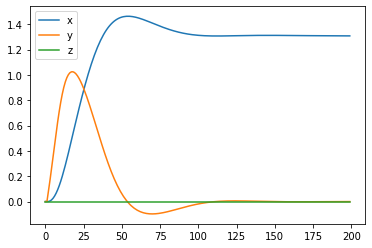

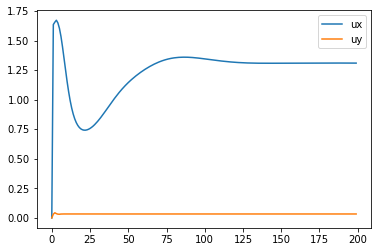

In [52]:
x_ob = np.array([3, 2, 0]).T
model = Model()
ctrl = C.controller(model, x_ob,f,H)
test(10,model,ctrl,x_ob)
